<div style="font-family: Trebuchet MS">
    <h1 style="font-family: Trebuchet MS; line-height:1.5; margin-bottom: -10px"><center>Classifying ASL Hand Signs on Synthetic Backgrounds using Image Segmentation and a Transformer Encoder Model</center></h1>
    <p><center>Shawson Hsiao, Brian Li, Tyler Hattori</center></p>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; letter-spacing: 0.5px"><center>Goal</center></h2>
    <ul>
        <li>Given an image of a hand blended onto a complicated background, identify what ASL number (0 to 9) the hand is signing</li>
        <li>Three tasks: (1) image blending, (2) image segmentation, (3) classification using AI</li>
    </ul>
    <center><img style="width: 80%" src="images/goal.png"></center>
</div>

<h2 style="font-family: Trebuchet MS; letter-spacing: 0.5px; margin-bottom: 60px"><center>ASL Numbering</center></h2>
<center><img style="width: 40%" src="images/asl.png"></center>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom:80px"><center>Image Blending</center></h2>
    <center><img style="width: 100%" src="images/blend.png"></center>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: -30px"><center>The Transformer Encoder</center></h2>
    <p><center><i>ASL hand sign recognition</i></center></p>
    <center><img style="width: 40%" src="images/encoder_params.png"></center>
    <ul>
        <li>Datsets: <i>Hand Gesture Recognition Datset</i> [1], <i>Sign Language Digits Datset</i> [2], <i>American Sign Language Digits</i> [3]</li>
        <li>97.9% accuracy on 3000 testing images from [1] (300 testing images for each digit)</li>
    </ul>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: -10px"><center>Preprocessing the Datasets</center></h2>
    <ul>
        <li>Images from the three datasets vary in size, shape, and right/left handedness</li>
    </ul>
    <center><img style="width: 60%; margin-bottom: -30px" src="images/dataset.png"></center>
    <ul>
        <li>However, the encoder input must be a sequence of tokens (integers)</li>
    </ul>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: 30px"><center>Preprocessing the Datasets</center></h2>
    <ul>
        <li>After each image is rescaled to be 20x20 with only 0s or 1s as entries, they are flattened into length 400 binary sequences</li>
        <li>By converting each set of 10 binary entries into decimal, each sequence is reduced to length 40</li>
        <li>This converts any image into 40 tokens with a vocab of 2048</li>
    </ul>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import skimage.measure
import cv2
import os

def trim(image,px=3):
    kernel = np.ones((px,px),np.uint8)
    return cv2.erode(image,kernel)

def pool(image):
    return cv2.resize(image,(20,20))

def binarize(image,threshold=135):
    N = np.size(image,1)
    return np.array([[1 if image[i][j] > threshold else 0 for j in range(N)] for i in range(N)],int)

def image2seq(image,Q=10):
    b = [pow(2,i) for i in range(Q)]
    image_flat = image.flatten()
    image_flat = np.append(image_flat,np.zeros(np.mod(len(image_flat),Q),int))
    seq = np.zeros(int(len(image_flat)/Q),int)
    for i in range(len(seq)):
        seq[i] = image_flat[i*Q:i*Q+Q] @ b
    return seq

In [2]:
def consolidate_datasets(threshold=135,type='train'):
    G = 10
    images = []
    for set in range(3):
        path = './gestures'+str(set+1)+'/'+type+'/'

        for gesture in range(G):
            gesture_idx = str(gesture)+'/'
            if set == 1: gesture_idx = 'A'+gesture_idx
            train_imgs = os.listdir(path+gesture_idx)

            for i in range(len(train_imgs)):
                img = mpimg.imread(path+gesture_idx+train_imgs[i])
                if set == 1: img = cv2.cvtColor(img[:,::-1], cv2.COLOR_BGR2HSV)[:,:,1]
                elif set == 2: img = img[:,::-1,0]

                if set == 0: threshold = 135
                else: threshold = 50

                if set == 2: px = 7
                else: px = 1

                img = np.array(binarize(img,threshold),float)
                img = trim(img,px)
                img = np.array(pool(img),int)
                seq = image2seq(img)
                entry = np.append(seq,gesture)
                images.append(entry)
    images = np.array(images,int)
    return images

In [3]:
def show_example_input(plot_images=True,set=2):
    train_path = './gestures'+str(set)+'/train/'
    gesture_idx = str(random.randint(0,9))+'/'
    if set == 2: gesture_idx = 'A'+gesture_idx
    train_imgs = os.listdir(train_path+gesture_idx)

    img_idx = random.randint(0,len(train_imgs))
    image = mpimg.imread(train_path+gesture_idx+train_imgs[img_idx])

    if set == 2: image2 = cv2.cvtColor(image[:,::-1], cv2.COLOR_BGR2HSV)[:,:,1]
    elif set == 3: image2 = image[:,::-1,0]
    else: image2 = image

    if set == 1: threshold = 135
    else: threshold = 50

    if set == 3: px = 7
    else: px = 1

    image3 = np.array(binarize(image2,threshold),float)
    image4 = trim(image3,px)
    image5 = np.array(pool(image4),int)
    images = [image,image2,image3,image4,image5]
    if plot_images:
        fig, axs = plt.subplot_mosaic([[i for i in range(len(images))]], layout='constrained')
        for label, ax in axs.items():
            ax.imshow(images[label])
        plt.show()

In [4]:
def seq2image(seq,Q=10,N=40):
    img = np.zeros(400,int)
    b = [pow(2,i) for i in range(Q)]
    for i in range(N):
        btoken = format(seq[i], 'b')
        btoken = np.append([0]*(Q-len(btoken)),[btoken[j] for j in range(len(btoken))])
        btoken = btoken[::-1]
        img[i*Q:i*Q+Q] = btoken
    img = img.reshape(20,20)
    return img

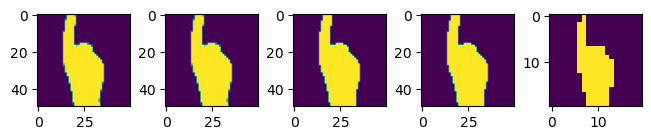

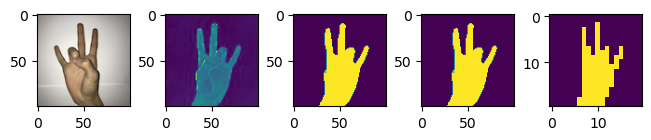

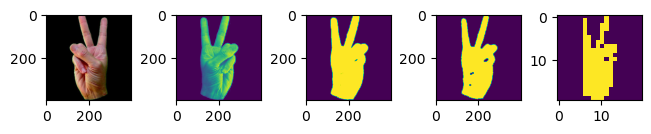

In [5]:
show_example_input(set=1)
show_example_input(set=2)
show_example_input(set=3)

In [ ]:
# create dataset
training = consolidate_datasets(type='train')
testing  = consolidate_datasets(type='test')

# split datasets into inputs and outputs
test_dataset_ordered = np.array([testing[i][:-1] for i in range(len(testing))], int)
test_labels_ordered = np.array([testing[i][-1] for i in range(len(testing))], int)
np.save('./dataset/testing_sequences_ordered',test_dataset_ordered)
np.save('./dataset/testing_labels_ordered',test_labels_ordered)

# shuffle dataset entries
np.random.shuffle(training)
np.random.shuffle(testing)

# split datasets into inputs and outputs
train_dataset = np.array([training[i][:-1] for i in range(len(training))], int)
train_labels = np.array([training[i][-1] for i in range(len(training))], int)
test_dataset = np.array([testing[i][:-1] for i in range(len(testing))], int)
test_labels = np.array([testing[i][-1] for i in range(len(testing))], int)
np.save('./dataset/training_sequences',train_dataset)
np.save('./dataset/training_labels',train_labels)
np.save('./dataset/testing_sequences',test_dataset)
np.save('./dataset/testing_labels',test_labels)

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS;"><center>The Dataset</center></h2>
</div>

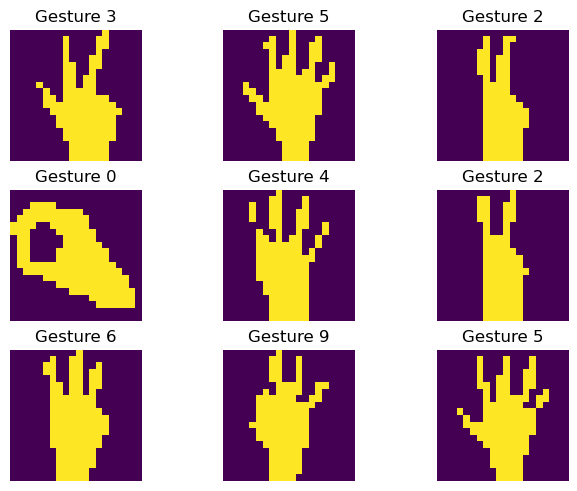

In [6]:
# plot nine random input sequences as images
inputs = np.load('./dataset/testing_sequences.npy')
outputs = np.load('./dataset/testing_labels.npy')
fig, axs = plt.subplot_mosaic([[random.randint(0,len(outputs)) for i in range(3)] for j in range(3)], layout='constrained')
for label, ax in axs.items():
    ax.set_title('Gesture '+str(outputs[label]))
    ax.imshow(seq2image(inputs[label]))
    ax.axis('off')
plt.show()

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: -30px"><center>The Model</center></h2>
    <p><center><i>ASL hand sign recognition</i></center></p>
    <p><center>Colab link:</center></p>
    <p><center>https://colab.research.google.com/drive/10FDxEMkoEqzlDQnufXqAp4f4BK8yGJW6?usp=sharing</center></p>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: -30px"><center>Test the Model</center></h2>
    <p><center><i>on test images from the dataset</i></center></p>
    <center><img style="width: 60%; margin-left:-6%" src="images/accuracies.png"></center>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: -30px"><center>Test the Model</center></h2>
    <p><center><i>on images found online</i></center></p>
    <center><img style="width: 100%" src="images/google.png"></center>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: -30px"><center>Test the Model</center></h2>
    <p><center><i>on non-blended images</i></center></p>
    <center><img style="width: 100%" src="images/shawson.png"></center>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: -30px"><center>Test the Model</center></h2>
    <p><center><i>on images from the simple segmentation method</i></center></p>
    <center><img style="width: 100%" src="images/otsu.png"></center>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: -30px"><center>Test the Model</center></h2>
    <p><center><i>on images from the otsu segmentation method</i></center></p>
    <center><img style="width: 100%" src="images/otsu.png"></center>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: -30px"><center>Test the Model</center></h2>
    <p><center><i>on images from the otsu controuring segmentation method</i></center></p>
    <center><img style="width: 100%" src="images/otsu_contour.png"></center>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: -30px"><center>Test the Model</center></h2>
    <p><center><i>on images from the adaptive controuring segmentation method</i></center></p>
    <center><img style="width: 100%" src="images/adaptive.png"></center>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: 30px"><center>Conclusion</center></h2>
    <ul>
        <li>The encoder is able to classify images with stark backgrounds, but performs poorly on noisy images</li>
        <li>In order for the encoder to learn to classify the segmented images, it would need a more robust dataset</li>
        <li>One idea: train the encoder on the Principal Components of the input image as opposed to the pixel values themselves. This may reduce the effect of noise</li>
    </ul>
</div>

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; margin-bottom: 0px"><center>References</center></h2>
    <p>[1] Arya, Rishabh. Hand Gesture Recognition Datset, 2021. https://www.kaggle.com/datasets/aryarishabh/hand-gesture-recognition-dataset.</p>
    <p>[2] Wani, Javaid. Sign Language Digits Datset, 2022. https://www.kaggle.com/datasets/javaidahmadwani/sign-language-digits-dataset.</p>
    <p>[3] Ofor, Victor. American Sign Language Digits, 2023. https://www.kaggle.com/datasets/victoranthony/asl-digits-0-9.</p>
</div>